# Question 1:  Who was tougher on the movies they were rating, viewers or critics?

# Definitions

WEIGHTED AVERAGE VOTE: IMDb registered users can cast a vote (from 1 to 10) on every released title in the database. Individual votes are then aggregated and summarized as a single IMDb rating. Users can update their votes as often as they’d like, but any new vote on the same title will overwrite the previous one, so it is one vote per title per user.

METACRITIC SCORE: A Metascore is a weighted average where IMDB assigns more importance, or weight, to some critics and publications than others, based on their quality and overall stature. A movie gets a Metascore when IMDB has collected at least four critics' reviews for that movie. Metascores range from 0-100, with higher scores indicating better overall reviews. IMDB also normalizes the resulting scores (akin to "grading on a curve" in college), which prevents scores from clumping together.

# Set-up and Initial review

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st

IMDB_movies = "Original Data/IMDb_movies.csv"
movies_data_raw = pd.read_csv(IMDB_movies)

In [3]:
movies_data_raw.shape

(81273, 22)

In [4]:
movies_data_raw.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics'],
      dtype='object')

In [5]:
movies_data = movies_data_raw.set_index(['title'])
movies_data_reduced = movies_data_raw[['title',  'avg_vote', 'metascore', 'reviews_from_users', 'reviews_from_critics', 'year']]
movies_data_reduced.head()

,title,avg_vote,metascore,reviews_from_users,reviews_from_critics,year
0,The Story of the Kelly Gang,6.1,NaN,7.0,7.0,1906
1,Den sorte drøm,5.9,NaN,4.0,2.0,1911
2,Cleopatra,5.2,NaN,24.0,3.0,1912
3,L'Inferno,7.0,NaN,28.0,14.0,1911
4,"From the Manger to the Cross; or, Jesus of Naz...",5.7,NaN,12.0,5.0,1912


# Data Cleaning

In [6]:
movies_data_reduced.count()

title                   81273
avg_vote                81273
metascore               12722
reviews_from_users      74196
reviews_from_critics    70286
year                    81273
dtype: int64

Only 74,196 of the total movies listed in IMDB have been reviewed by viewers, and only 70,286 have been reviewed by critics.  So the first step is to eliminate the movies that do not have reviews by BOTH viewers and critics.

Additionally, and more importantly, only 12,722 movies have been given a metascore - meaning they were reviewed by at least 4 critics and assigned a score rating the qulaity of the movie.  Without a metascore, we can not measure how critics rated the quality the movie. 

Thus, the dataset must be limited to only the movies with an assigned metascore that have also been reviwed by viewers.

In [7]:
movies_data= movies_data_reduced.dropna(how='any')
movies_data.count()

title                   12662
avg_vote                12662
metascore               12662
reviews_from_users      12662
reviews_from_critics    12662
year                    12662
dtype: int64

# Review Ratings: summary stats

In [43]:
#CALCULATE SUMARY STATS ABOUT FILM QUALITY---------------------------------------------
review_data = movies_data[['title',  'avg_vote', 'metascore']]

reviews_mean = round(review_data.mean(numeric_only=True),2)
reviews_median = round(review_data.median(numeric_only=True),2)
reviews_variance = round(review_data.var(numeric_only=True),2)
reviews_stddev = round(review_data.std(numeric_only=True),2)
reviews_SEM = round(review_data.sem(numeric_only=True),2)

#CREATE DATAFRAME---------------------------------------------------------------------
reviews_summary = pd.DataFrame({"Mean Rating": reviews_mean,
                              "Median Rating": reviews_median,
                              "Rating Variance": reviews_variance,
                              "Rating Std Dev": reviews_stddev,
                              "Rating SEM": reviews_SEM})
reviews_summary


,Mean Rating,Median Rating,Rating Variance,Rating Std Dev,Rating SEM
avg_vote,6.35,6.4,0.95,0.97,0.01
metascore,55.77,56.0,314.90,17.75,0.16


# Number of Reviews: summary stats

In [45]:
reviews_volume = movies_data[['reviews_from_users', 'reviews_from_critics']]

vol_total = reviews_volume.sum()
vol_means = round(reviews_volume.mean(),2)
vol_medians = round(reviews_volume.median(),2)
vol_variance = round(reviews_volume.var(),2)
vol_stddev = round(reviews_volume.std(),2)
vol_SEM = round(reviews_volume.sem(),2)

#CREATE DATAFRAME---------------------------------------------------------------------
reviews_volume_stats = pd.DataFrame({"Total # of Reviews": vol_total,
                                     "Mean # of Reviews": vol_means,
                                     "Median # of Reviews": vol_medians ,
                                     "Reviews Volume Variance": vol_variance,
                                     "Reviews Volume Std Dev": vol_stddev,
                                     "Reviews Volume SEM": vol_SEM})

reviews_volume_stats

,Total # of Reviews,Mean # of Reviews,Median # of Reviews,Reviews Volume Variance,Reviews Volume Std Dev,Reviews Volume SEM
reviews_from_users,2269464.0,179.23,71.0,122881.87,350.55,3.12
reviews_from_critics,1286996.0,101.64,66.0,11274.84,106.18,0.94


# Scatterplots and boxplots of Average Viewer Ratings & Critic Metascores

# Quartiles and Outliers

In [10]:
ave_vote = movies_data['avg_vote']
metascore = movies_data['metascore']

ave_vote_quartiles = ave_vote.quantile([.25,.5,.75])
ave_vote_lowerq = ave_vote_quartiles[0.25]
ave_vote_upperq = ave_vote_quartiles[0.75]
ave_vote_iqr = ave_vote_upperq-ave_vote_lowerq
ave_vote_lower_bound = ave_vote_lowerq - (1.5*ave_vote_iqr)
ave_vote_upper_bound = ave_vote_upperq + (1.5*ave_vote_iqr)

metascore_quartiles = metascore.quantile([.25,.5,.75])
metascore_lowerq = metascore_quartiles[0.25]
metascore_upperq = metascore_quartiles[0.75]
metascore_iqr = metascore_upperq-metascore_lowerq
metascore_lower_bound = metascore_lowerq - (1.5*metascore_iqr)
metascore_upper_bound = metascore_upperq + (1.5*metascore_iqr)

print(f"Lower Quartile of Viewer Reviews: {round(ave_vote_lowerq,2)}")
print(f"Upper Quartile of Viewer Reviews: {round(ave_vote_upperq,2)}")
print(f"Viewer Review IQR: {round(ave_vote_iqr,2)}")
print(f"Outliers: below {round(ave_vote_lower_bound,2)} or above {round(ave_vote_upper_bound,2)}")
print("--------------------------------------------------------------------------")
print(f"Lower Quartile of Critic Metascores: {round(metascore_lowerq,2)}")
print(f"Upper Quartile of Critic Metascores: {round(metascore_upperq,2)}")
print(f"Critic Metascore IQR: {round(metascore_iqr,2)}")
print(f"Outliers: below {round(metascore_lower_bound,2)} or above {round(metascore_upper_bound,2)}")


Lower Quartile of Viewer Reviews: 5.8
Upper Quartile of Viewer Reviews: 7.0
Viewer Review IQR: 1.2
Outliers: below 4.0 or above 8.8
--------------------------------------------------------------------------
Lower Quartile of Critic Metascores: 43.0
Upper Quartile of Critic Metascores: 69.0
Critic Metascore IQR: 26.0
Outliers: below 4.0 or above 108.0


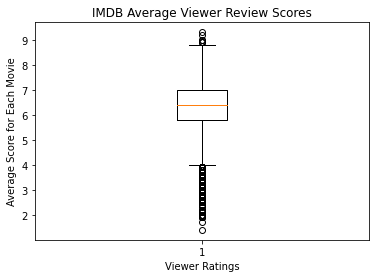

In [11]:
fig1, ax1 = plt.subplots()
ax1.set_title('IMDB Average Viewer Review Scores')
ax1.set_ylabel('Average Score for Each Movie')
ax1.set_xlabel('Viewer Ratings')
ax1.boxplot(ave_vote)
plt.show()

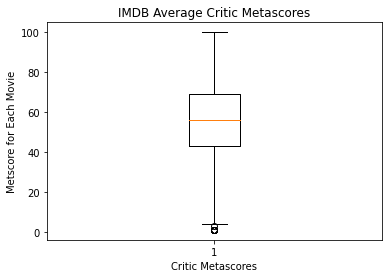

In [12]:
fig1, ax1 = plt.subplots()
ax1.set_title('IMDB Average Critic Metascores')
ax1.set_ylabel('Metscore for Each Movie')
ax1.set_xlabel('Critic Metascores')
ax1.boxplot(metascore)
plt.show()

# Relationship between user scores and critic scores

The r-squared is: 0.6930274308647507


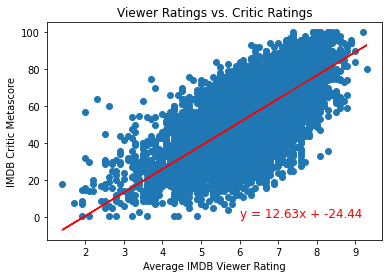

In [13]:
# DEPENDENCIES --------------------------------------------------------------
from scipy.stats import linregress

# CALCULATE VARIABLES--------------------------------------------------------
review_data_by_title = review_data.set_index(['title'])
ave_vote = review_data_by_title['avg_vote']
metascore = review_data_by_title['metascore']

# PLOT GRAPH-----------------------------------------------------------------
x_values = ave_vote
y_values = metascore
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,0),fontsize=12,color="red")
plt.title('Viewer Ratings vs. Critic Ratings')
plt.xlabel('Average IMDB Viewer Rating')
plt.ylabel('IMDB Critic Metascore')
print(f"The r-squared is: {rvalue}")
plt.show()

OBSERVATIONS: 

Overall, There is a positive correlation between higher viewer scores and critic metascores.

There are a far greater numbers of overall user reviews than critic reviews, but more consitstency (less variance and Standard deviation) in the number of critic reviews of any given movie recived vs. the number of user reviews each movie recieved. 

However, there seems to be much more variability (variance and standard deviation) in the quality ratings given to movies by critics than by users. That is to say, even if each movie was reviewed by more viewers than critics, there was more consistency among what the viwers thought of the quality of the movie than what the critics thought. It should also be noted that there are may more outliers present in the viwer review data than the critic metascores, but this in part reflects that the metscores have been set to a normal curve as part of IMDB's methodology.

As far as a direct comparison of how well users rated movie vs. critics, we have to keep in mind that according to the metascore methodology applied by IMDB, the critic review metascores are already normalized (i.e. adjusted to a normal curve). Additionally, the viewer ratings are scales from 1-10 while the metascores are scaled 1-100, so they may not be directly comparable without additional statistial analysis. However, if we compare the average criitc metascore relative to its range (1-100) to the average voter score relative to its range (1-10), viwers do seem to rate movies overall slight more favorably than critics. 

# Review stats broken down by decade

In [14]:
earliest_film = movies_data['year'].min()
earliest_film

1916

In [15]:
most_recent_film = movies_data['year'].max()
most_recent_film

2019

In [51]:
#CREATE BINS BY DECADE ----------------------------------------------------
decade = [1910, 1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 1999, 2009, 2019]
decade_names = ["1910s", "1920s", "1930s", "1940s", "1950s", "1960s", "1970s", "1980s", "1990s", "2000s", "2010s"]
movies_data["Decade"] = pd.cut(movies_data["year"], decade, labels=decade_names)

C:\Users\Vlad\AppData\Local\Temp/ipykernel_88944/2717426972.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_data["Decade"] = pd.cut(movies_data["year"], decade, labels=decade_names)


In [52]:
# GROUPBY DECADE BINS---------------------------------------------------------------------------------------------
decade_group = movies_data.groupby('Decade')
number_of_movies = decade_group["year"].count()
print(number_of_movies)

# CALCULATE DECADE STATS---------------------------------------------------------------------------------------------
decade_summary = decade_group[["avg_vote", "metascore", "reviews_from_users", "reviews_from_critics"]].mean()

# FORMAT OUTPUTS----------------------------------------------------------------------------------------------------
decade_summary["avg_vote"] = decade_summary["avg_vote"].map("{:.2f}".format)
decade_summary["metascore"] = decade_summary["metascore"].map("{:.2f}".format)
decade_summary["reviews_from_users"] = decade_summary["reviews_from_users"].map("{:.2f}".format)
decade_summary["reviews_from_critics"] = decade_summary["reviews_from_critics"].map("{:.2f}".format)

# ADD A COLUMN FOR NUMBER OF MOVIES IN IMDB FOR EACH DECADE---------------------------------------------------------
decade_summary["Number of Movies"]= number_of_movies

# RELABEL DATAFRAME COLUMNS-----------------------------------------------------------------------------------------
decade_summary_renamed = decade_summary.rename(columns={"avg_vote":"Average Viewer Rating", "metascore":"Average Critic Metascore", "reviews_from_users":"Ave # Viewer Reviews per movie", "reviews_from_critics":"Ave # Critic Reviews per movie"})

decade_summary_renamed

Decade
1910s       1
1920s       4
1930s      25
1940s      39
1950s      89
1960s     208
1970s     400
1980s     880
1990s    1403
2000s    4050
2010s    5563
Name: year, dtype: int64


,Average Viewer Rating,Average Critic Metascore,Ave # Viewer Reviews per movie,Ave # Critic Reviews per movie,Number of Movies
Decade,,,,,
1910s,7.80,93.00,105.00,77.00,1
1920s,7.55,85.75,231.00,83.75,4
1930s,7.60,87.40,252.24,100.92,25
1940s,7.58,84.95,253.51,92.92,39
1950s,7.64,81.33,200.39,85.40,89
1960s,7.32,72.80,182.25,74.41,208
1970s,6.93,65.12,176.79,77.35,400
1980s,6.51,55.06,154.97,69.39,880
1990s,6.54,56.70,209.16,68.63,1403


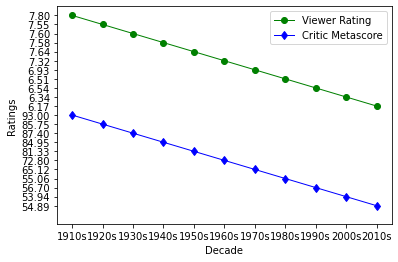

In [18]:
# CREATE VARIABLES FOR LINE GRAPH--------------------------------------
viewerrating = decade_summary_renamed["Average Viewer Rating"]
criticratings = decade_summary_renamed["Average Critic Metascore"]

# PLOT GRAPH-----------------------------------------------------------
Viewer_Ratings, = plt.plot(decade_names, viewerrating, marker="o",color="green", linewidth=1, label="Viewer Rating")
Critic_Ratings, = plt.plot(decade_names, criticratings, marker="d",color="blue", linewidth=1, label="Critic Metascore")

plt.legend(handles=[Viewer_Ratings, Critic_Ratings], loc="best")
plt.xlabel("Decade")
plt.ylabel("Ratings")
plt.ylim((23,-1))
plt.show()

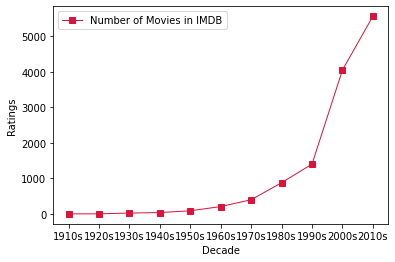

In [19]:
movieslisted = decade_summary_renamed["Number of Movies"]
Movies_Listed, = plt.plot(decade_names, movieslisted, marker="s",color="crimson", linewidth=1, label="Number of Movies in IMDB")
plt.legend(handles=[Movies_Listed], loc="best")
plt.xlabel("Decade")
plt.ylabel("Ratings")
plt.show()

OBSERVATIONS: 

On average, both viwers and critics rated movies from the 1960s and earlier higher than movies made in the 1970s and after. However, the vast majority of the movies in IMDB were made in the 1970s and afterwards.  It could be that the better the quality of movies made before 1070, the more likely it is to be listed and reviewed on IMDB.  More recent movies might be more likely to be listed on IMDB regardless of quality, thus bring the average scores for reviews of recent movies down. 

# Viewer vs Critic Ratings for top 100 movies

# Viewers' Top 100 Movies

In [20]:
# IDENTIFY TOP 100 MOVIES BY VIEWER RATINGS ----------------------------------------
movies_data_viewers_descending = movies_data.sort_values("avg_vote", ascending=False)
viewer_best_unlabeled = movies_data_viewers_descending.head(100)
viewer_best = viewer_best_unlabeled.rename(columns={"avg_vote":"Average Viewer Rating", "metascore":"Average Critic Metascore", "reviews_from_users":"# Viewer Reviews", "reviews_from_critics":"# Critic Reviews"})

viewer_best.head()

,title,Average Viewer Rating,Average Critic Metascore,# Viewer Reviews,# Critic Reviews,year,Decade
27628,The Shawshank Redemption,9.3,80.0,7029.0,224.0,1994,1990s
14943,The Godfather,9.2,100.0,3362.0,241.0,1972,1970s
15954,The Godfather: Part II,9.0,90.0,857.0,172.0,1974,1970s
46756,The Dark Knight,9.0,84.0,6344.0,418.0,2008,2000s
26817,Schindler's List,8.9,94.0,1642.0,221.0,1993,1990s


In [21]:
# CALCULATE AVERAGES FOR VIEWER TOP 100--------------------------------------------
viewer_best_avescore = viewer_best["Average Viewer Rating"].mean()
viewer_best_metascore = viewer_best["Average Critic Metascore"].mean()
viewer_best_viewernum = viewer_best["# Viewer Reviews"].mean()
viewer_best_criticnum = viewer_best["# Critic Reviews"].mean()
viewer_best_aveyear = viewer_best["year"].mean()

# CREATE DATAFRAME ---------------------------------------------------------------
viewer_best_summary = pd.DataFrame({"Average Viewer Rating": [viewer_best_avescore],
                                  "Average Metascore": [viewer_best_metascore],
                                  "Average # Viewer Reviews per movie": [viewer_best_viewernum],
                                  "Average # Critic Reviews per movie": [viewer_best_criticnum],
                                  "Average Year of Release": [viewer_best_aveyear]})

viewer_best_summary

,Average Viewer Rating,Average Metascore,Average # Viewer Reviews per movie,Average # Critic Reviews per movie,Average Year of Release
0,8.525,81.76,1444.18,245.75,1990.8


# Critics' Top 100 Movies

In [22]:
# IDENTIFY TOP 100 MOVIES BY CRITIC METASCORE ----------------------------------------
movies_data_critics_descending = movies_data.sort_values("metascore", ascending=False)
critic_best_unlabeled = movies_data_critics_descending.head(100)
critic_best = critic_best_unlabeled.rename(columns={"avg_vote":"Average Viewer Rating", "metascore":"Average Critic Metascore", "reviews_from_users":"# Viewer Reviews", "reviews_from_critics":"# Critic Reviews"})

critic_best.head()

,title,Average Viewer Rating,Average Critic Metascore,# Viewer Reviews,# Critic Reviews,year,Decade
8912,Sweet Smell of Success,8.1,100.0,143.0,127.0,1957,1950s
3277,The Wizard of Oz,8.0,100.0,641.0,160.0,1939,1930s
51644,Boyhood,7.9,100.0,949.0,576.0,2014,2010s
12019,Au hasard Balthazar,7.9,100.0,77.0,109.0,1966,1960s
7738,Rear Window,8.4,100.0,759.0,145.0,1954,1950s


In [23]:
# CALCULATE AVERAGES FOR CRITICS TOP 100--------------------------------------------
critic_best_avescore = critic_best["Average Viewer Rating"].mean()
critic_best_metascore = critic_best["Average Critic Metascore"].mean()
critic_best_viewernum = critic_best["# Viewer Reviews"].mean()
critic_best_criticnum = critic_best["# Critic Reviews"].mean()
critic_best_aveyear = critic_best["year"].mean()

# CREATE DATAFRAME-----------------------------------------------------------------
critic_best_movies = pd.DataFrame({"Average Viewer Rating": [critic_best_avescore],
                                  "Average Metascore": [critic_best_metascore],
                                  "Average # Viewer Reviews per movie": [critic_best_viewernum],
                                  "Average # Critic Reviews per movie": [critic_best_criticnum],
                                  "Average Year of Release": [critic_best_aveyear]})

critic_best_movies

,Average Viewer Rating,Average Metascore,Average # Viewer Reviews per movie,Average # Critic Reviews per movie,Average Year of Release
0,7.989,96.58,542.83,211.76,1973.07


# Viewers' Bottom 100 Movies

In [24]:
# IDENTIFY BOTTOM 100 MOVIES BY VIEWER RATINGS ----------------------------------------
movies_data_viewers_ascending = movies_data.sort_values("avg_vote", ascending=True)
viewer_worst_unlabeled = movies_data_viewers_ascending.head(100)
viewer_worst = viewer_worst_unlabeled.rename(columns={"avg_vote":"Average Viewer Rating", "metascore":"Average Critic Metascore", "reviews_from_users":"# Viewer Reviews", "reviews_from_critics":"# Critic Reviews"})

viewer_worst.head()

,title,Average Viewer Rating,Average Critic Metascore,# Viewer Reviews,# Critic Reviews,year,Decade
70807,Saving Christmas,1.4,18.0,156.0,27.0,2014,2010s
37709,The Price of Air,1.7,8.0,6.0,14.0,2000,2000s
38202,Superbabies: Baby Geniuses 2,1.9,9.0,127.0,36.0,2004,2000s
53363,Disaster Movie,1.9,15.0,399.0,110.0,2008,2000s
40967,The Singing Forest,1.9,1.0,36.0,4.0,2003,2000s


In [25]:
# CALCULATE AVERAGES FOR VIEWER BOTTOM 100--------------------------------------------
viewer_worst_avescore = viewer_worst["Average Viewer Rating"].mean()
viewer_worst_metascore = viewer_worst["Average Critic Metascore"].mean()
viewer_worst_viewernum = viewer_worst["# Viewer Reviews"].mean()
viewer_worst_criticnum = viewer_worst["# Critic Reviews"].mean()
viewer_worst_aveyear = viewer_worst["year"].mean()

# CREATE DATAFRAME-------------------------------------------------------------------
viewer_worst_summary = pd.DataFrame({"Average Viewer Rating": [viewer_worst_avescore],
                                  "Average Metascore": [viewer_worst_metascore],
                                  "Average # Viewer Reviews per movie": [viewer_worst_viewernum],
                                  "Average # Critic Reviews per movie": [viewer_worst_criticnum],
                                  "Average Year of Release": [viewer_worst_aveyear]})

viewer_worst_summary

,Average Viewer Rating,Average Metascore,Average # Viewer Reviews per movie,Average # Critic Reviews per movie,Average Year of Release
0,2.812,22.72,152.69,46.77,2007.04


# Critics' Bottom 100 Movies

In [26]:
# IDENTIFY BOTTOM 100 MOVIES BY CRITIC METASCORE ----------------------------------------
movies_data_critics_ascending = movies_data.sort_values("metascore", ascending=True)
critic_worst_unlabeled = movies_data_critics_ascending.head(100)
critic_worst = critic_worst_unlabeled.rename(columns={"avg_vote":"Average Viewer Rating", "metascore":"Average Critic Metascore", "reviews_from_users":"# Viewer Reviews", "reviews_from_critics":"# Critic Reviews"})

critic_worst.head()

,title,Average Viewer Rating,Average Critic Metascore,# Viewer Reviews,# Critic Reviews,year,Decade
28688,Bio-Dome,4.4,1.0,141.0,29.0,1996,1990s
66310,United Passions,2.1,1.0,32.0,9.0,2014,2010s
59421,InAPPropriate Comedy,2.8,1.0,49.0,22.0,2013,2010s
61419,10 Rules for Sleeping Around,3.6,1.0,8.0,14.0,2013,2010s
22467,The Garbage Pail Kids Movie,2.6,1.0,116.0,43.0,1987,1980s


In [27]:
# CALCULATE AVERAGES FOR CRITIC BOTTOM 100--------------------------------------------
critic_worst_avescore = critic_worst["Average Viewer Rating"].mean()
critic_worst_metascore = critic_worst["Average Critic Metascore"].mean()
critic_worst_viewernum = critic_worst["# Viewer Reviews"].mean()
critic_worst_criticnum = critic_worst["# Critic Reviews"].mean()
critic_worst_aveyear = critic_worst["year"].mean()

# CREATE DATAFRAME -------------------------------------------------------------------
critic_worst_summary = pd.DataFrame({"Average Viewer Rating": [critic_worst_avescore],
                                  "Average Metascore": [critic_worst_metascore],
                                  "Average # Viewer Reviews per movie": [critic_worst_viewernum],
                                  "Average # Critic Reviews per movie": [critic_worst_criticnum],
                                  "Average Year of Release": [critic_worst_aveyear]})

critic_worst_summary

,Average Viewer Rating,Average Metascore,Average # Viewer Reviews per movie,Average # Critic Reviews per movie,Average Year of Release
0,4.086,8.99,131.52,46.9,2004.52


OBSERVATIONS:

Viewers' favorite 100 movies had an average viewer rating of 8.525, and average critic metascore of 81.76
Crictic's favorite movies had an average viewer rating of 7.989, and average critic metascore of 96.58
An interesting point is the difference in "average year of release" for the viewers' favorite movies (1990), and critics' favorite movies (1973), indicating that critics favor older films more than IMDB users. 

Viewers' least favorite 100 movies had an average viewer rating of 2.812, and average critic metascore of 22.72
Crictic's least favorite movies had an average viewer rating of 4.086, and average critic metascore of 8.99
However, both IMDB users and critics had similar "average year of release" for bad movies -- the 2010s for both groups (2007 vs. 2004). 
    

# Viewer Ratings - detailed breakdown

In [28]:
# IMPORT DATA----------------------------------------------------------
IMDB_ratings = "Original Data/IMDb_ratings.csv"
ratings_data_raw = pd.read_csv(IMDB_ratings)
ratings_data_raw.head()

,imdb_title_id,weighted_average_vote,total_votes,mean_vote,median_vote,votes_10,votes_9,votes_8,votes_7,votes_6,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0000574,6.1,537,6.3,6.0,54,17,55,121,122,...,6.0,19.0,6.6,14.0,6.3,64.0,6.0,89.0,6.2,309.0
1,tt0001892,5.9,171,6.1,6.0,5,6,17,41,52,...,5.8,4.0,6.5,8.0,5.9,29.0,6.2,27.0,6.0,114.0
2,tt0002101,5.2,420,5.2,5.0,12,8,16,60,89,...,5.5,14.0,6.2,20.0,4.9,57.0,5.5,197.0,4.7,103.0
3,tt0002130,7.0,2019,6.9,7.0,194,208,386,571,308,...,7.3,74.0,7.4,75.0,7.0,126.0,7.1,452.0,7.0,1076.0
4,tt0002199,5.7,438,5.8,6.0,28,15,42,75,114,...,4.8,10.0,6.5,15.0,5.7,56.0,5.9,161.0,5.7,164.0


In [29]:
ratings_data_raw.shape

(81273, 49)

In [53]:
ratings_data_raw.columns

Index(['imdb_title_id', 'weighted_average_vote', 'total_votes', 'mean_vote',
       'median_vote', 'votes_10', 'votes_9', 'votes_8', 'votes_7', 'votes_6',
       'votes_5', 'votes_4', 'votes_3', 'votes_2', 'votes_1',
       'allgenders_0age_avg_vote', 'allgenders_0age_votes',
       'allgenders_18age_avg_vote', 'allgenders_18age_votes',
       'allgenders_30age_avg_vote', 'allgenders_30age_votes',
       'allgenders_45age_avg_vote', 'allgenders_45age_votes',
       'males_allages_avg_vote', 'males_allages_votes', 'males_0age_avg_vote',
       'males_0age_votes', 'males_18age_avg_vote', 'males_18age_votes',
       'males_30age_avg_vote', 'males_30age_votes', 'males_45age_avg_vote',
       'males_45age_votes', 'females_allages_avg_vote',
       'females_allages_votes', 'females_0age_avg_vote', 'females_0age_votes',
       'females_18age_avg_vote', 'females_18age_votes',
       'females_30age_avg_vote', 'females_30age_votes',
       'females_45age_avg_vote', 'females_45age_votes',
       

In [31]:
#CALCULATE OVERALL AVERAGE VOTES BY GENDER -----------------------------
overall_rating = ratings_data_raw['weighted_average_vote']
mean_females_rating = ratings_data_raw['females_allages_avg_vote']
mean_males_rating = ratings_data_raw['males_allages_avg_vote']
ratingslists_by_gender = pd.DataFrame({"Ave Rating Overall": overall_rating, 
                                       "Ave Female Rating": mean_females_rating, 
                                       "Ave Male Rating": mean_males_rating})

ratings_by_gender = ratingslists_by_gender.mean()
round(ratings_by_gender,2)

Ave Rating Overall    5.93
Ave Female Rating     6.06
Ave Male Rating       5.85
dtype: float64

In [32]:
# CALCULATE MEANS FOR RATINGS, DIVIDED BY GENDER, SEPARATED BY AGES RANGE----------
allgenders_ratings = ratings_data_raw[['allgenders_0age_avg_vote', 'allgenders_18age_avg_vote', 'allgenders_30age_avg_vote', 'allgenders_45age_avg_vote']]
allgenders_ratings_ave = allgenders_ratings.mean()

females_ratings = ratings_data_raw[['females_0age_avg_vote', 'females_18age_avg_vote', 'females_30age_avg_vote', 'females_45age_avg_vote']]
females_ratings_ave = females_ratings.mean()

males_ratings = ratings_data_raw[['males_0age_avg_vote', 'males_18age_avg_vote', 'males_30age_avg_vote', 'males_45age_avg_vote']]
males_ratings_ave = males_ratings.mean()

# CREATE DATAFRAMES FOR GENDER & AGE BREAKDOWNS-----------------------------------
allgender_ratings_ages = pd.DataFrame({"Ave Overall": allgenders_ratings_ave})
females_ratings_ages = pd.DataFrame({"Ave Females": females_ratings_ave})
males_ratings_ages = pd.DataFrame({"Ave Males": males_ratings_ave})

# RESET INDEXES FOR EACH DATAFRAME TO MATCH EACHOTHER------------------------------
allgender_ages_indexed = allgender_ratings_ages.rename(index={'allgenders_0age_avg_vote': 'Ages 0-17','allgenders_18age_avg_vote':'Ages 18-29','allgenders_30age_avg_vote':'Ages 30-44', 'allgenders_45age_avg_vote':'Ages 45+'})
female_ages_indexed = females_ratings_ages.rename(index={'females_0age_avg_vote': 'Ages 0-17','females_18age_avg_vote':'Ages 18-29','females_30age_avg_vote':'Ages 30-44', 'females_45age_avg_vote':'Ages 45+'})
male_ages_indexed = males_ratings_ages.rename(index={'males_0age_avg_vote': 'Ages 0-17','males_18age_avg_vote':'Ages 18-29','males_30age_avg_vote':'Ages 30-44', 'males_45age_avg_vote':'Ages 45+'})

# CREATE NEW COMBINED DATAFRAME----------------------------------------------------
gender_ratings_by_age = round(allgender_ages_indexed, 2) 
gender_ratings_by_age["Female Ave Rating"] = round(female_ages_indexed, 2)
gender_ratings_by_age["Male Ave Rating"] = round(male_ages_indexed, 2)

gender_ratings_by_age

,Ave Overall,Female Ave Rating,Male Ave Rating
Ages 0-17,6.59,6.85,6.58
Ages 18-29,6.04,6.26,6.00
Ages 30-44,5.88,6.10,5.84
Ages 45+,5.69,6.06,5.64


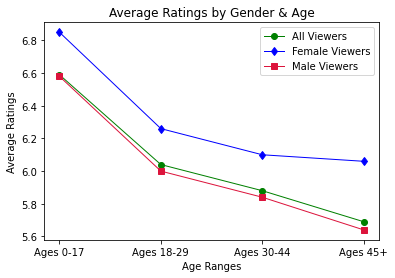

In [33]:
# CREATE VARIABLES FOR LINE GRAPH--------------------------------------
ages = ['Ages 0-17', 'Ages 18-29', 'Ages 30-44', 'Ages 45+']
females = gender_ratings_by_age["Female Ave Rating"]
males = gender_ratings_by_age["Male Ave Rating"]
combinedgender = gender_ratings_by_age["Ave Overall"]

# PLOT GRAPH-----------------------------------------------------------
All_Viewers, = plt.plot(ages, combinedgender, marker="o",color="green", linewidth=1, label="All Viewers")
Female_Viewers, = plt.plot(ages, females, marker="d",color="blue", linewidth=1, label="Female Viewers")
Male_Viewers, = plt.plot(ages, males, marker="s",color="crimson", linewidth=1, label="Male Viewers")

plt.legend(handles=[All_Viewers, Female_Viewers, Male_Viewers], loc="best")
plt.xlabel("Age Ranges")
plt.ylabel("Average Ratings")
plt.title("Average Ratings by Gender & Age")
plt.show()

In [34]:
#CALCULATE OVERALL AVERAGE VOTES BY GEOGRAPHY------------------------------------
US_ratings = ratings_data_raw['us_voters_rating']
ave_US_ratings = US_ratings.mean()

non_US_ratings = ratings_data_raw['non_us_voters_rating']
ave_non_US_ratings = non_US_ratings.mean()

ratingslists_by_geography = pd.DataFrame({"Ave US Voter Rating": US_ratings,
                                          "Ave non-US Voter Rating": non_US_ratings})

ratings_by_geography = ratingslists_by_geography.mean()
round(ratings_by_geography,2)

Ave US Voter Rating        5.97
Ave non-US Voter Rating    5.78
dtype: float64

OBSERVATIONS:

In general, females viewers rate movies slightly more favorably than male viewers. This trend is consistent across all age ranges when the data are divide by age. Older viewers (both male and female) consistently give less favorable ratings than viewers younger than them. 

Average ratings from US viewers also tended to be slightly higher than ratings from viewers in other countries.